# Hypsometric analysis for recent landslides

In [36]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sbn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx
import pysal

import warnings
warnings.filterwarnings("ignore")

### Catchments

In [37]:
catchments=gpd.read_file("../Data/hypso3.gpkg")
catchments.head(2)

,OBJECTID,Id,gridcode,Área,hypso_inte,area_curva,Shape_Leng,Shape_Le_1,Shape_Area,Nombre,Lineamient,Densidad,_mean,knickpoint,geometry
0,1,4.0,2827.0,120.181924,0.107,0.096448,59628.024115,59459.370531,1.201791e+08,Quebrada Los San Andreses,294.0,2.446291,2250.332866,E,"MULTIPOLYGON (((411860.438 900002.542, 411964...."
1,2,36.0,3161.0,33.492364,0.334,0.321148,41322.987731,41322.987731,3.349236e+07,Quebrada Sabalito,0.0,0.000000,3457.470653,A,"MULTIPOLYGON (((505464.576 881616.272, 505673...."


In [38]:
catchments.drop(["Id",'gridcode','area_curva','Shape_Leng','Shape_Le_1','Shape_Area','Lineamient'],axis=1,inplace=True)

,OBJECTID,Área,hypso_inte,Nombre,Densidad,rainfall_cat,knickpoint,geometry
0,1,120.181924,0.107,Quebrada Los San Andreses,2.446291,2250.332866,E,"MULTIPOLYGON (((411860.438 900002.542, 411964...."
1,2,33.492364,0.334,Quebrada Sabalito,0.000000,3457.470653,A,"MULTIPOLYGON (((505464.576 881616.272, 505673...."


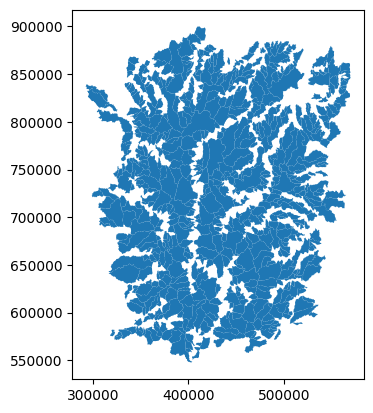

In [39]:
cat=catchments.to_crs(epsg=32618)
cat.rename(columns={"_mean":"rainfall_cat"}, inplace=True)
cat.plot()
cat.head(2)

## Recent landslides

In [40]:
recent=gpd.read_file("../Data/recent2_rainfall.gpkg")
recent.head(2)

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,date,source,elevation1,rainfall1,geometry
0,NaN,NaN,NaT,NaT,NaT,NaN,-1,0,-1,NaN,NaN,09/2006,My Places — _Points_,2363.0,2068.415506,POINT Z (439722.005 681812.005 0.000)
1,NaN,NaN,NaT,NaT,NaT,NaN,-1,0,-1,NaN,NaN,09/2011,My Places — _Points_,2881.0,2319.148033,POINT Z (437541.797 675246.253 0.000)


Se eliminan las columnas que nos e van a utilizar

In [41]:
rece=recent.drop(["Name","description","timestamp","begin","end","altitudeMode","tessellate","extrude","visibility","drawOrder","icon"],axis=1)

 Se cambia el nombre de la columna que tiene la lluvia, y se proyecta a coordenadas planas.

,date,source,elevation1,rainfall1,geometry
0,09/2006,My Places — _Points_,2363.0,2068.415506,POINT Z (439722.005 681812.005 0.000)
1,09/2011,My Places — _Points_,2881.0,2319.148033,POINT Z (437541.797 675246.253 0.000)


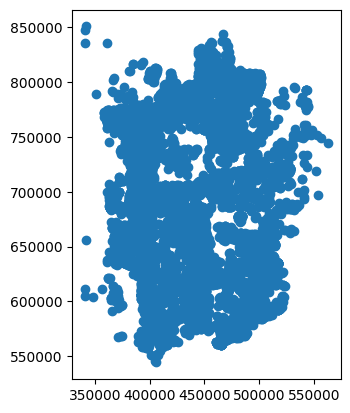

In [42]:
rece=rece.to_crs(epsg=32618)
rece.rename(columns={"SAMPLE_1":"rainfall_rec"}, inplace=True)
rece.plot()
rece.head(2)

Se realiza una interseccion espacial entre las cuencas 'cat' y los movimientos en masa recientes 'rec'. se agrupa por el numero de la cuenca para saber cuantos movimientos en masa hay por cuenca con la columna 'OBJECTID' que es unica (no tiene valores repetidos, cada cuenca tiene un valor unico) y se crea una dataframe.

NOTA= La columna "Nombre" no es unica, hay algunas pocas cuencas con el mismo nombre.

In [43]:
rec_join = gpd.sjoin(rece, cat, how="inner")
rec_by_cat=rec_join.groupby("OBJECTID").size()
rec_cat=pd.DataFrame({"rec_count": rec_by_cat})
rec_cat.head(2)

,rec_count
OBJECTID,
53,1
69,2


Se realiza un joint (no espacial) entre las cuencas 'cat' y el dataframe con el numero de movimientos en masa por cuenca 'land_cat' utilizando la columna 'OBJECTID' que es unica, y se crea una nueva columna con la densidad de movimientos en masa. Donde no hay movimientos en masa aparece un NaN.

In [44]:
rec = cat.join(rec_cat,on="OBJECTID") 
rec["rec_density"] = rec["rec_count"]/rec["Área"]
rec.head(2)

,OBJECTID,Área,hypso_inte,Nombre,Densidad,rainfall_cat,knickpoint,geometry,rec_count,rec_density
0,1,120.181924,0.107,Quebrada Los San Andreses,2.446291,2250.332866,E,"MULTIPOLYGON (((411860.438 900002.542, 411964....",NaN,NaN
1,2,33.492364,0.334,Quebrada Sabalito,0.000000,3457.470653,A,"MULTIPOLYGON (((505464.576 881616.272, 505673....",NaN,NaN


Se crean nuevas columnas para el numero de movimientos en masa y para hipsometria para solo las cuencas con movimientso en masa y para solo las ceuncas sin movimientos en masa, para poder graficar mejor.

In [45]:
rec["rec_count"]=rec["rec_count"].fillna(0) #column with all catchments (with and without landslides)
rec["rec_count_landcat"]=rec["rec_count"].replace(0,np.nan) #column with only catchments with landslides
rec["rec_count_Nolandcat"]=np.where(rec["rec_count"]>0,np.nan,rec["rec_count"]) #column with only catchments without landslides
rec["hypso_landcat"]=np.where(rec["rec_count"]==0,np.nan,rec["hypso_inte"])
rec["hypso_Nolandcat"]=np.where(rec["rec_count"]>0,np.nan,rec["hypso_inte"])
rec['hypso_with']=rec['hypso_landcat'].fillna(0)
rec['hypso_without']=rec['hypso_Nolandcat'].fillna(0)
rec['landslides']=np.where(rec["rec_count"]>0,'Recent lands.','No lands.')
rec.head(2)

,OBJECTID,Área,hypso_inte,Nombre,Densidad,rainfall_cat,knickpoint,geometry,rec_count,rec_density,rec_count_landcat,rec_count_Nolandcat,hypso_landcat,hypso_Nolandcat,hypso_with,hypso_without,landslides
0,1,120.181924,0.107,Quebrada Los San Andreses,2.446291,2250.332866,E,"MULTIPOLYGON (((411860.438 900002.542, 411964....",0.0,NaN,NaN,0.0,NaN,0.107,0.0,0.107,No lands.
1,2,33.492364,0.334,Quebrada Sabalito,0.000000,3457.470653,A,"MULTIPOLYGON (((505464.576 881616.272, 505673....",0.0,NaN,NaN,0.0,NaN,0.334,0.0,0.334,No lands.


## Relict landslides

In [46]:
relict=gpd.read_file("../Data/relict_rainfall.gpkg")
relict.head(2)

,Name,descriptio,timestamp,begin,end,altitudeMo,tessellate,extrude,visibility,drawOrder,icon,SAMPLE_1,geometry
0,El Guasimo,NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,1841.776395,POINT Z (-75.86709 6.80850 753.10776)
1,El Noral,NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,1946.703969,POINT Z (-75.50832 6.36266 1592.60560)


<Axes: >

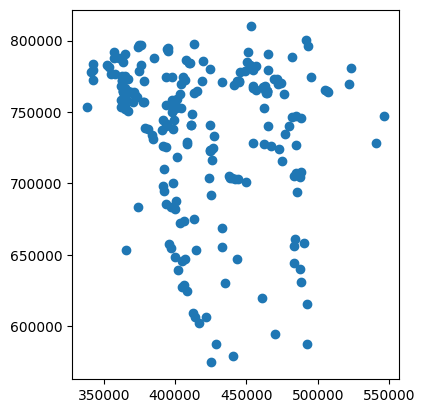

In [47]:
reli=relict.drop(["Name","descriptio","timestamp","begin","end","altitudeMo","tessellate","extrude","visibility","drawOrder","icon"],axis=1)
reli.rename(columns={"SAMPLE_1":"rainfall_rel"}, inplace=True)
reli=reli.to_crs(epsg=32618)
reli.plot()

In [48]:
rele_cat = gpd.sjoin(reli, cat, how="inner")
rel_by_cat=rele_cat.groupby("OBJECTID").size()
rel_cat=pd.DataFrame({"rel_count": rel_by_cat})
rel_cat.head(2)

,rel_count
OBJECTID,
97,2
107,1


In [49]:
rel = cat.join(rel_cat,on="OBJECTID")
rel["rel_density"] = rel["rel_count"]/rel["Área"]
rel.head(2)

,OBJECTID,Área,hypso_inte,Nombre,Densidad,rainfall_cat,knickpoint,geometry,rel_count,rel_density
0,1,120.181924,0.107,Quebrada Los San Andreses,2.446291,2250.332866,E,"MULTIPOLYGON (((411860.438 900002.542, 411964....",NaN,NaN
1,2,33.492364,0.334,Quebrada Sabalito,0.000000,3457.470653,A,"MULTIPOLYGON (((505464.576 881616.272, 505673....",NaN,NaN


In [50]:
rel["rel_count"]=rel["rel_count"].fillna(0) #column with all catchments (with and without landslides)
rel["rel_count_landcat"]=rel["rel_count"].replace(0,np.nan) #column with only catchments with landslides
rel["rel_count_Nolandcat"]=np.where(rel["rel_count"]>0,np.nan,rel["rel_count"]) #column with only catchments without landslides
rel["hypso_landcat"]=np.where(rel["rel_count"]==0,np.nan,rel["hypso_inte"])
rel["hypso_Nolandcat"]=np.where(rel["rel_count"]>0,np.nan,rel["hypso_inte"])
rel['hypso_with']=rel['hypso_landcat'].fillna(0)
rel['hypso_without']=rel['hypso_Nolandcat'].fillna(0)
rel['landslides']=np.where(rel["rel_count"]>0,'Ancient lands.','No lands.')
rel.head(2)

,OBJECTID,Área,hypso_inte,Nombre,Densidad,rainfall_cat,knickpoint,geometry,rel_count,rel_density,rel_count_landcat,rel_count_Nolandcat,hypso_landcat,hypso_Nolandcat,hypso_with,hypso_without,landslides
0,1,120.181924,0.107,Quebrada Los San Andreses,2.446291,2250.332866,E,"MULTIPOLYGON (((411860.438 900002.542, 411964....",0.0,NaN,NaN,0.0,NaN,0.107,0.0,0.107,No lands.
1,2,33.492364,0.334,Quebrada Sabalito,0.000000,3457.470653,A,"MULTIPOLYGON (((505464.576 881616.272, 505673....",0.0,NaN,NaN,0.0,NaN,0.334,0.0,0.334,No lands.


#### Import dataframe catchments

In [51]:
cat_9 = pd.read_csv("../Data/df2.csv")
cat_9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Nombre              643 non-null    object 
 1   ID_CUENCA           643 non-null    float64
 2   cuenca              643 non-null    object 
 3   area                643 non-null    int64  
 4   geometry            643 non-null    object 
 5   hypso_inte          643 non-null    float64
 6   _Ksmean             643 non-null    float64
 7   _chimean            643 non-null    float64
 8   rainfall_cat        643 non-null    float64
 9   Densidad            643 non-null    float64
 10  elev_mean           643 non-null    float64
 11  slope_mean          643 non-null    float64
 12  rel_mean            643 non-null    float64
 13  kmeans              643 non-null    object 
 14  RainfallDaysmean    643 non-null    float64
 15  RainfallDaysmedian  643 non-null    float64
 16  Rainfall

In [52]:
cat_rel=cat_9[cat_9["lands_rel"]>0]
cat_rec=cat_9[cat_9["lands_rec"]>0]
cat_land=cat_9[cat_9["landslides"]>0]
cat_nland=cat_9[cat_9["landslides"]==0]

In [53]:
cat_cauca=cat_9[(cat_9["cuenca"]=="Cauca")]
cat_magda=cat_9[(cat_9["cuenca"]=="Magdalena")]
cat_atrato=cat_9[(cat_9["cuenca"]=="Atrato")]

## Figura

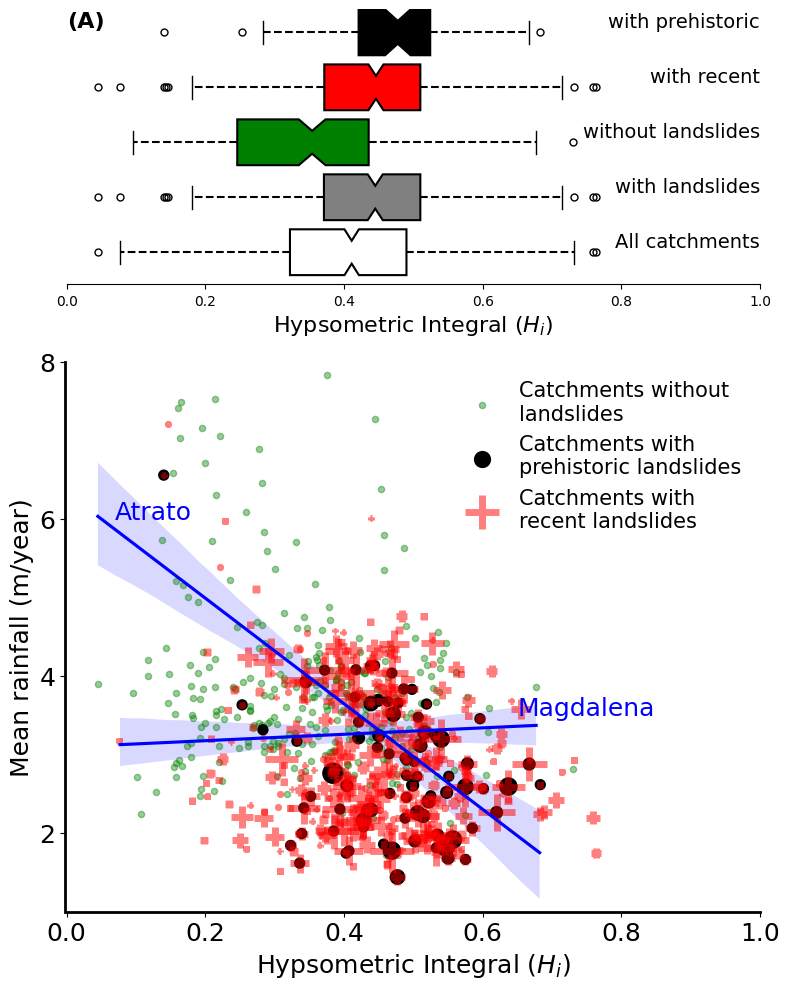

In [54]:
f, ax = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={'height_ratios': [1, 2]}, sharex=True)

# Upper plot (ax[0])
bplot = ax[0].boxplot([cat_9["hypso_inte"], cat_land["hypso_inte"], cat_nland["hypso_inte"], 
                       cat_rec["hypso_inte"], cat_rel["hypso_inte"]],
                      vert=False,
                      patch_artist=True,
                      widths=1,
                      boxprops=dict(linewidth=1.5),
                      showmeans=False,
                      meanline=False,
                      notch=True,
                      whiskerprops=dict(linestyle="dashed", linewidth=1.5),
                      flierprops=dict(marker="o", markersize=5, markeredgecolor="black"),
                      medianprops=dict(linestyle="solid", linewidth=0),
                      positions=[0.7, 1.9, 3.1, 4.3, 5.5])

# Fill with colors
colors = ['white', 'gray', 'green', 'red', 'black']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Adjust x-axis to match the lower plot
ax[0].set_xlim(0, 1)  # Set x-axis limits to match ax[1]
ax[0].set_xticks(np.arange(0, 1.001, 0.2))  # Add x-ticks
ax[0].set_xticklabels([f"{tick:.1f}" for tick in np.arange(0, 1.001, 0.2)], fontsize=14)  # Add explicit tick labels
ax[0].xaxis.set_tick_params(labelbottom=True)  # Force tick labels to show
ax[0].set_xlabel('Hypsometric Integral ($H_i$)', fontsize=16)  # Add shared x-axis label
ax[0].set_ylim(0, 6)

# Eliminate the y-axis for the upper plot
ax[0].tick_params(left=False)  # Disable y-axis ticks
ax[0].set_yticklabels([])  # Remove y-axis labels
ax[0].spines['left'].set_visible(False)  # Hide the left spine

# Remove unnecessary decorations
sbn.despine(ax=ax[0], left=True, offset={'left': 20})
ax[0].text(0.0, 5.6, "(A)", size=16, weight='bold')

# Add text annotations aligned to the same x-coordinate (0.95) and aligned to the right
ax[0].text(1, 0.8, 'All catchments', color='black', weight='roman', size=14, ha='right')
ax[0].text(1, 2, 'with landslides', color='black', weight='roman', size=14, ha='right')
ax[0].text(1, 3.2, 'without landslides', color='black', weight='roman', size=14, ha='right')
ax[0].text(1, 4.4, 'with recent', color='black', weight='roman', size=14, ha='right')
ax[0].text(1, 5.6, 'with prehistoric', color='black', weight='roman', size=14, ha='right')


# Lower plot (ax[1])
sbn.regplot(x=cat_atrato["hypso_inte"], y=cat_atrato["rainfall_cat"]/1000, ax=ax[1], marker=".", 
            color="white", line_kws=dict(color="blue"))
sbn.regplot(x=cat_magda["hypso_inte"], y=cat_magda["rainfall_cat"]/1000, ax=ax[1], marker=".", 
            color="white", line_kws=dict(color="blue"))
ax[1].scatter(rec["hypso_Nolandcat"], rec["rainfall_cat"]/1000, s=80, facecolors='green', 
              marker=".", edgecolors='green', color="green", alpha=0.4, label="Catchments without \nlandslides")
ax[1].scatter(rel["hypso_landcat"], rel["rainfall_cat"]/1000, edgecolor='black', marker=".", 
              linewidths=5, s=rel["rel_count"]*40, color='black', label="Catchments with \nprehistoric landslides")
ax[1].scatter(rec["hypso_landcat"], rec["rainfall_cat"]/1000, edgecolor='red', marker='+', 
              linewidths=5, s=rec["rec_count"]*4, color='red', alpha=0.5, label="Catchments with \nrecent landslides")

ax[1].set_xlabel('Hypsometric Integral ($H_i$)', size=18)
ax[1].set_ylabel('Mean rainfall (m/year)', size=18)
ax[1].set_yticks(np.arange(0, 8.1, 2))
ax[1].set_xticks(np.arange(0, 1.001, 0.2))
ax[1].tick_params(axis='y', labelsize=18)
ax[1].tick_params(axis='x', labelsize=18)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(1, 8)
for axis in ['bottom', 'left']:
    ax[1].spines[axis].set_linewidth(2)
sbn.despine(ax=ax[1], offset={'left': 1})

# Additional styling
plt.text(0.07, 6, 'Atrato', fontsize=18, color='blue')
plt.text(0.65, 3.5, 'Magdalena', fontsize=18, color='blue')
plt.legend(loc="upper right", frameon=False, prop={'size': 15})
f.tight_layout()
plt.savefig("../Rev1/Figuras/Fig6A.png", dpi=500)
